SERS Plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

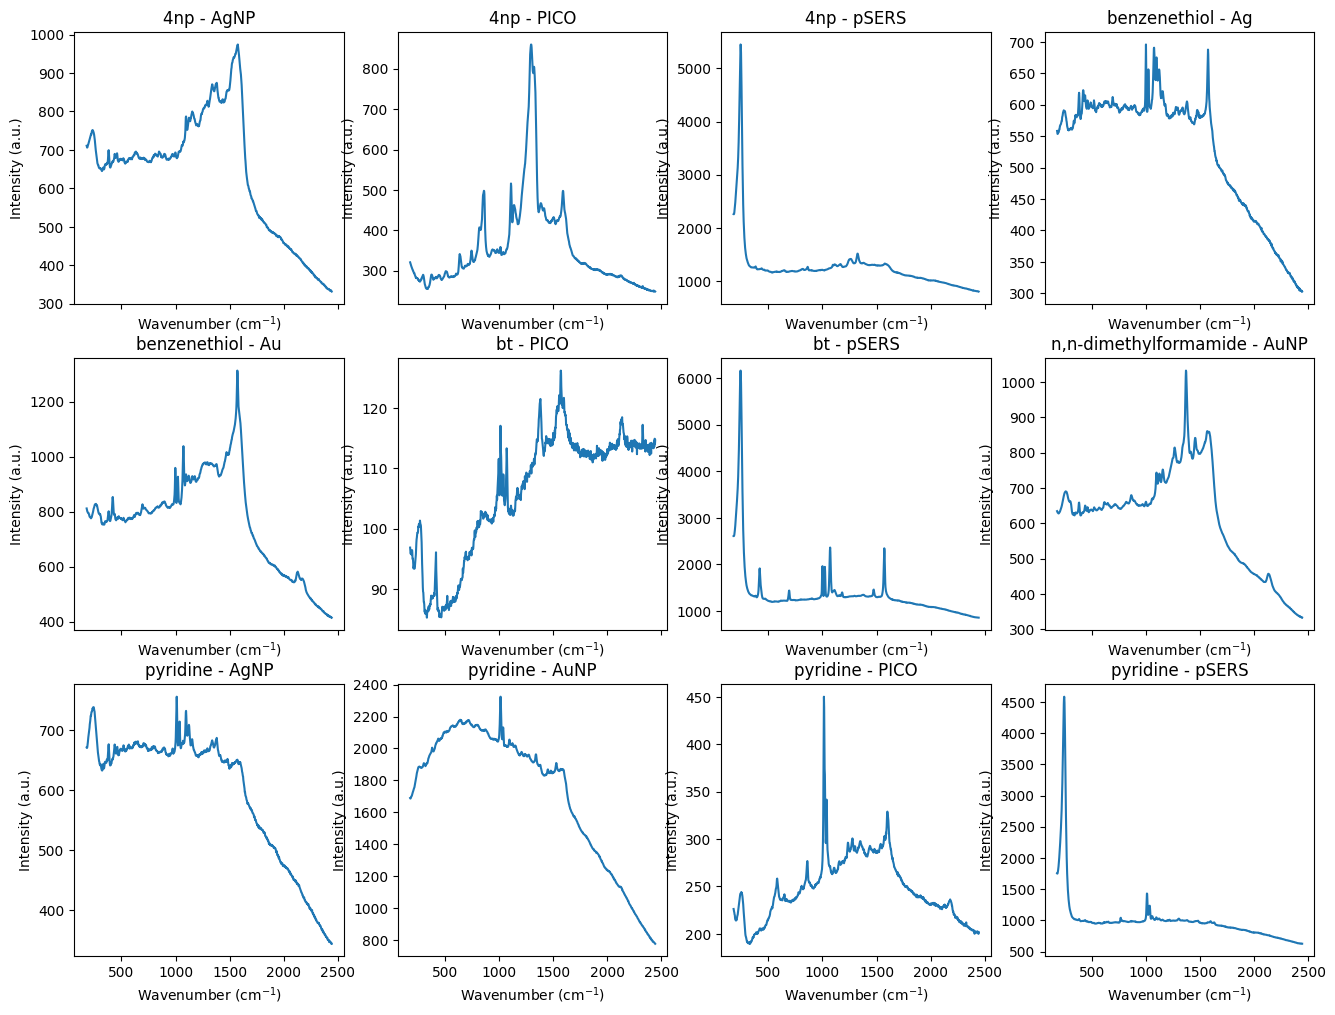

In [11]:
df= pd.read_csv('consolidated_SERS_avg.csv')

spec_cols = [c for c in df.columns if c not in ('Label','Substrate','Class')]
wavenumbers = np.array(spec_cols,dtype=float)

n = len(df)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))

fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*4,ncols*3),sharex=True)
axes = np.array(axes).reshape(-1)

for ax, (_,row) in zip(axes,df.iterrows()):
    spectrum = row[spec_cols].values.astype(float)
    ax.plot(wavenumbers, spectrum)
    ax.set_title(f"{row['Label']} - {row['Substrate']}")
    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax.set_ylabel('Intensity (a.u.)')


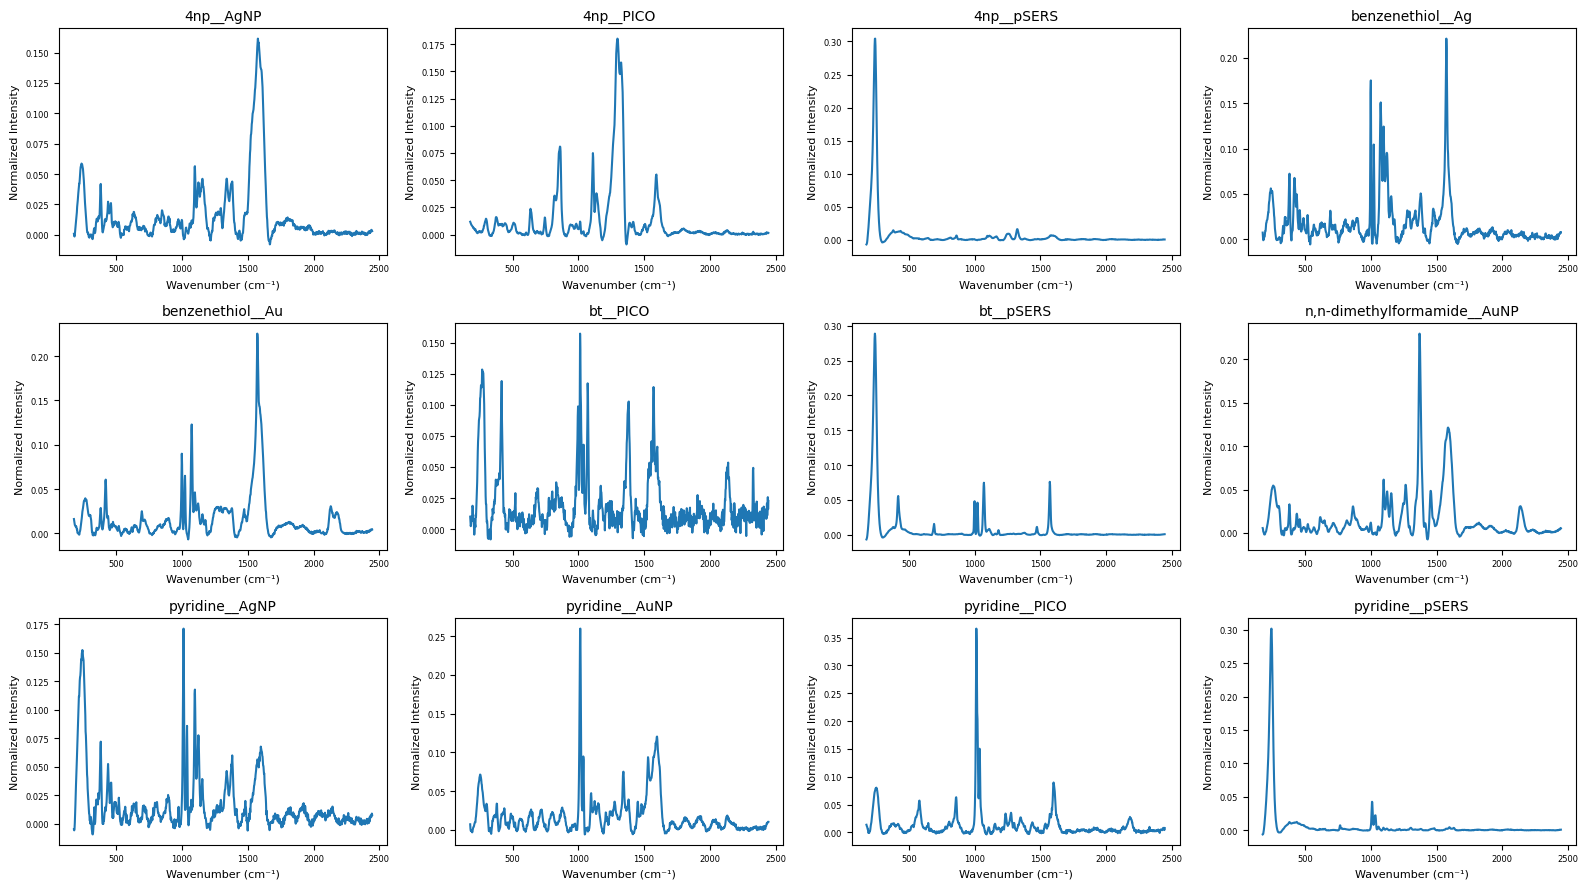

In [13]:
def baseline_AsLS(y,lam=1e4,p=0.01,niter =10):
    L =len(y)
    D = np.diff(np.eye(L),2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_AsLS(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out
spectra = df[spec_cols].values.astype(float)
proc_spectra = preprocess(spectra)

n = len(df)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))

# 6) Create subplots (independent scales)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
axes = axes.ravel()

# 7) Plot each preprocessed average spectrum
for ax, (_, row), proc in zip(axes, df.iterrows(), proc_spectra):
    ax.plot(wavenumbers, proc)
    ax.set_title(f"{row['Label']}__{row['Substrate']}", fontsize=10)
    ax.set_xlabel('Wavenumber (cm⁻¹)', fontsize=8)
    ax.set_ylabel('Normalized Intensity', fontsize=8)
    ax.tick_params(axis='both', labelsize=6)

# 8) Remove any unused axes
for ax in axes[n:]:
    fig.delaxes(ax)

# 9) Layout and display
plt.tight_layout()
plt.show()